# Hand Gesture Presentation Controller Pipeline

This notebook implements the five-phase plan captured in `pipeline.md` so we can go from Roboflow Pascal VOC annotations to a deployable hand-gesture presentation controller.

- **Phase 1:** Parse VOC XML files and crop gesture ROIs into a clean dataset structure.
- **Phase 2:** Convert crops into fixed-length HOG descriptors.
- **Phase 3:** Train and evaluate a conventional classifier (linear/RBF SVM).
- **Phase 4:** Connect the classifier to a webcam ROI + `pyautogui` control loop.
- **Phase 5:** Collect artifacts for the written report and demo video.


## Workspace Checklist
- Code runs from the repo root: `HandGesturePresentationController/`.
- Raw Pascal VOC data lives under `Dataset_roboflow/{train,valid,test}`.
- Cropped conventional dataset will be stored in `dataset_final/{split}/{label}` (mirrors Phase 1 of the pipeline).
- Fallback conventional data (if any) can be read from the legacy `Dataset/{Back,Next}` directories.
- Artifacts (CSV manifests, trained models, charts) are saved inside `artifacts/` for report inclusion.


In [1]:
# Uncomment and run once if the environment is missing any of these dependencies.
# %pip install -q numpy pandas scikit-image scikit-learn matplotlib opencv-python pillow joblib pyautogui seaborn



In [2]:
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple
import xml.etree.ElementTree as ET

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_rows", 10)

BASE_DIR = Path.cwd()
ROBOFLOW_DATASET = BASE_DIR / "Dataset_roboflow"
PROCESSED_DATASET = BASE_DIR / "dataset_final"
FALLBACK_DATASET = BASE_DIR / "Dataset"
ARTIFACTS_DIR = BASE_DIR / "artifacts"
MODEL_BUNDLE_PATH = ARTIFACTS_DIR / "gesture_svm.pkl"

SPLITS: Sequence[str] = ("train", "valid", "test")
ALLOWED_IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
TARGET_IMAGE_SIZE: Tuple[int, int] = (128, 128)
HOG_PARAMS: Dict[str, object] = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "transform_sqrt": True,
    "block_norm": "L2-Hys",
    "feature_vector": True,
}
LABEL_MAP = {"next": "next", "back": "previous", "prev": "previous"}
RANDOM_STATE = 42

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATASET.mkdir(parents=True, exist_ok=True)

print(f"Project root: {BASE_DIR}")
print(f"Roboflow dataset: {ROBOFLOW_DATASET.exists()} | Processed dataset: {PROCESSED_DATASET.exists()}")


Project root: c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController
Roboflow dataset: True | Processed dataset: True


## Phase 1 - Data Pre-processing (XML Parsing + Cropping)
Goals:
- Parse every Pascal VOC XML from Roboflow (`Dataset_roboflow`) and extract bounding boxes.
- Normalize labels (`next`, `back` -> `previous`).
- Crop the gesture region, optionally adding a small padding, and save it under `dataset_final/{split}/{label}` as required by `pipeline.md`.
- Produce a CSV manifest that can be cited in the report (counts per split/label, augmentation notes, etc.).


In [3]:
def parse_annotation_file(xml_path: Path) -> List[Dict[str, int]]:
    """Return all bounding boxes defined in a Pascal VOC XML file."""
    try:
        tree = ET.parse(xml_path)
    except ET.ParseError as exc:
        raise ValueError(f"Failed to parse {xml_path}: {exc}") from exc

    root = tree.getroot()
    objects: List[Dict[str, int]] = []
    for obj in root.findall("object"):
        raw_label = obj.findtext("name", default="").strip().lower()
        bbox = obj.find("bndbox")
        if not raw_label or bbox is None:
            continue
        xmin = int(float(bbox.findtext("xmin", default="0")))
        xmax = int(float(bbox.findtext("xmax", default="0")))
        ymin = int(float(bbox.findtext("ymin", default="0")))
        ymax = int(float(bbox.findtext("ymax", default="0")))
        objects.append({"label": raw_label, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax})
    return objects


def resolve_image_for_xml(xml_path: Path) -> Path:
    """Find the image file that shares the same stem as the XML annotation."""
    candidates = [xml_path.with_suffix(ext) for ext in (".jpg", ".jpeg", ".png", ".bmp")]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"No image file found for {xml_path}")


def collect_crop_jobs(split_dir: Path) -> List[Dict[str, object]]:
    jobs: List[Dict[str, object]] = []
    for xml_path in sorted(split_dir.glob("*.xml")):
        image_path = resolve_image_for_xml(xml_path)
        for obj in parse_annotation_file(xml_path):
            normalized_label = LABEL_MAP.get(obj["label"], None)
            if normalized_label is None:
                continue
            jobs.append(
                {
                    "split": split_dir.name,
                    "label": normalized_label,
                    "image_path": image_path,
                    "xmin": obj["xmin"],
                    "ymin": obj["ymin"],
                    "xmax": obj["xmax"],
                    "ymax": obj["ymax"],
                }
            )
    return jobs


def crop_hand(job: Dict[str, object], output_root: Path, pad_ratio: float = 0.08) -> Path:
    image = Image.open(job["image_path"]).convert("RGB")
    width, height = image.size
    w = job["xmax"] - job["xmin"]
    h = job["ymax"] - job["ymin"]
    pad_w = int(w * pad_ratio)
    pad_h = int(h * pad_ratio)
    x0 = max(0, job["xmin"] - pad_w)
    y0 = max(0, job["ymin"] - pad_h)
    x1 = min(width, job["xmax"] + pad_w)
    y1 = min(height, job["ymax"] + pad_h)
    crop = image.crop((x0, y0, x1, y1))

    dest_dir = output_root / job["split"] / job["label"]
    dest_dir.mkdir(parents=True, exist_ok=True)
    dest_path = dest_dir / f"{job['split']}_{job['label']}_{job['image_path'].stem}_{x0}_{y0}_{x1}_{y1}.jpg"
    crop.save(dest_path)
    return dest_path


def run_phase_one(execute: bool = False, pad_ratio: float = 0.08) -> pd.DataFrame:
    """Optionally crop all annotations and return a manifest DataFrame."""
    all_jobs: List[Dict[str, object]] = []
    for split in SPLITS:
        split_dir = ROBOFLOW_DATASET / split
        if not split_dir.exists():
            continue
        all_jobs.extend(collect_crop_jobs(split_dir))

    if not all_jobs:
        raise FileNotFoundError("No Pascal VOC annotations were found. Verify Dataset_roboflow/ is populated.")

    print(f"Located {len(all_jobs)} bounding boxes across {len(set(job['split'] for job in all_jobs))} splits.")
    if not execute:
        print("Dry run mode: set execute=True to create/refresh dataset_final/.")
        return pd.DataFrame(all_jobs)

    cropped_records: List[Dict[str, object]] = []
    for job in all_jobs:
        dest_path = crop_hand(job, PROCESSED_DATASET, pad_ratio=pad_ratio)
        record = {**job, "crop_path": dest_path.as_posix()}
        cropped_records.append(record)

    manifest = pd.DataFrame(cropped_records)
    manifest.to_csv(ARTIFACTS_DIR / "crop_manifest.csv", index=False)
    print(f"Saved {len(manifest)} crops -> {ARTIFACTS_DIR / 'crop_manifest.csv'}")
    return manifest


In [4]:
CROP_DATA = False  # Switch to True when you are ready to refresh dataset_final/
phase_one_manifest = run_phase_one(execute=CROP_DATA, pad_ratio=0.08)

if phase_one_manifest is not None:
    display(phase_one_manifest.head())


Located 195 bounding boxes across 3 splits.
Dry run mode: set execute=True to create/refresh dataset_final/.


,split,label,image_path,xmin,ymin,xmax,ymax
0,train,next,c:\Users\ASUS\Documents\Computer Vision\HandGe...,86,240,492,393
1,train,next,c:\Users\ASUS\Documents\Computer Vision\HandGe...,86,240,492,393
2,train,next,c:\Users\ASUS\Documents\Computer Vision\HandGe...,86,240,492,393
3,train,next,c:\Users\ASUS\Documents\Computer Vision\HandGe...,130,152,357,311
4,train,next,c:\Users\ASUS\Documents\Computer Vision\HandGe...,130,152,357,311


## Phase 2 - Feature Extraction (Grayscale + Resize + HOG)
Goals:
- Load every cropped image, convert to grayscale, and resize to the fixed `128x128` target required by SVM.
- Extract HOG descriptors using the parameters defined in `HOG_PARAMS`.
- Persist the feature matrix (NumPy `.npz`) and a metadata table (CSV) so we can reuse them without recomputing.
- Produce quick sanity-check visuals/statistics for the written report.


In [5]:
def dataset_has_images(root: Path) -> bool:
    if not root.exists():
        return False
    return any(root.rglob("*.jpg")) or any(root.rglob("*.png"))


def resolve_feature_dataset_root(preferred: Path, fallback: Path) -> Path:
    if dataset_has_images(preferred):
        return preferred
    if dataset_has_images(fallback):
        print(f"Warning: {preferred} is empty; using fallback {fallback}")
        return fallback
    raise FileNotFoundError("No cropped dataset found. Run Phase 1 or place images under Dataset/.")


def iter_image_paths(dataset_root: Path, splits: Sequence[str] | None = None):
    has_split_structure = any((dataset_root / split).exists() for split in SPLITS)
    if has_split_structure:
        target_splits = splits if splits else [p.name for p in dataset_root.iterdir() if p.is_dir()]
        for split in target_splits:
            split_dir = dataset_root / split
            if not split_dir.exists():
                continue
            for label_dir in sorted(p for p in split_dir.iterdir() if p.is_dir()):
                for image_path in sorted(label_dir.iterdir()):
                    if image_path.suffix.lower() in ALLOWED_IMAGE_EXTS:
                        yield split, label_dir.name.lower(), image_path
    else:
        for label_dir in sorted(p for p in dataset_root.iterdir() if p.is_dir()):
            for image_path in sorted(label_dir.iterdir()):
                if image_path.suffix.lower() in ALLOWED_IMAGE_EXTS:
                    yield "all", label_dir.name.lower(), image_path


def compute_hog_descriptor(image_path: Path, target_size: Tuple[int, int], hog_params: Dict[str, object]) -> np.ndarray:
    image = Image.open(image_path).convert("L").resize(target_size)
    image_arr = np.asarray(image, dtype=np.float32) / 255.0
    return hog(image_arr, **hog_params)


def build_feature_set(
    dataset_root: Path,
    target_size: Tuple[int, int],
    hog_params: Dict[str, object],
    splits: Sequence[str] | None = None,
    persist: bool = True,
) -> Tuple[np.ndarray, pd.DataFrame]:
    records: List[Dict[str, object]] = []
    feature_rows: List[np.ndarray] = []

    for split_name, label_name, image_path in iter_image_paths(dataset_root, splits=splits):
        descriptor = compute_hog_descriptor(image_path, target_size, hog_params)
        feature_rows.append(descriptor)
        records.append({
            "split": split_name,
            "label": LABEL_MAP.get(label_name, label_name),
            "image_path": image_path.as_posix(),
        })

    if not feature_rows:
        raise ValueError(f"No eligible images found under {dataset_root}")

    feature_matrix = np.vstack(feature_rows)
    meta_df = pd.DataFrame(records)

    if persist:
        np.savez_compressed(ARTIFACTS_DIR / "hog_features.npz", X=feature_matrix, y=meta_df["label"].values)
        meta_df.to_csv(ARTIFACTS_DIR / "hog_metadata.csv", index=False)
        print(f"Persisted features -> {ARTIFACTS_DIR / 'hog_features.npz'}")
        print(f"Persisted metadata -> {ARTIFACTS_DIR / 'hog_metadata.csv'}")

    return feature_matrix, meta_df


In [6]:
feature_dataset_root = resolve_feature_dataset_root(PROCESSED_DATASET, FALLBACK_DATASET)
print(f"Using processed dataset at: {feature_dataset_root}")

X, feature_meta = build_feature_set(feature_dataset_root, TARGET_IMAGE_SIZE, HOG_PARAMS, persist=True)
print(f"Feature matrix shape: {X.shape}")
print("Label distribution:\n", feature_meta["label"].value_counts())

feature_meta.head()


Using processed dataset at: c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\Dataset
Persisted features -> c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\artifacts\hog_features.npz
Persisted metadata -> c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\artifacts\hog_metadata.csv
Feature matrix shape: (82, 8100)
Label distribution:
 label
previous    41
next        41
Name: count, dtype: int64
Persisted features -> c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\artifacts\hog_features.npz
Persisted metadata -> c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\artifacts\hog_metadata.csv
Feature matrix shape: (82, 8100)
Label distribution:
 label
previous    41
next        41
Name: count, dtype: int64


,split,label,image_path
0,all,previous,c:/Users/ASUS/Documents/Computer Vision/HandGe...
1,all,previous,c:/Users/ASUS/Documents/Computer Vision/HandGe...
2,all,previous,c:/Users/ASUS/Documents/Computer Vision/HandGe...
3,all,previous,c:/Users/ASUS/Documents/Computer Vision/HandGe...
4,all,previous,c:/Users/ASUS/Documents/Computer Vision/HandGe...


## Phase 3 - Model Training + Evaluation (SVM)
Goals:
- Split the HOG feature matrix into train/test (default 80/20 with stratification).
- Train both linear and RBF-flavored SVMs; keep the best-performing option.
- Report accuracy, precision, recall, and a confusion matrix for the written report.
- Persist the trained model (`gesture_svm.pkl`) along with preprocessing metadata for later inference.


In [7]:
def train_and_select_svm(
    features: np.ndarray,
    labels: Sequence[str],
    test_size: float = 0.2,
    random_state: int = RANDOM_STATE,
):
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size=test_size,
        stratify=labels,
        random_state=random_state,
    )

    kernel_grid = [
        {"name": "linear", "params": {"kernel": "linear", "C": 1.0}},
        {"name": "rbf", "params": {"kernel": "rbf", "C": 5.0, "gamma": "scale"}},
    ]

    best_result = None
    evaluations = []

    for cfg in kernel_grid:
        clf = SVC(probability=True, class_weight="balanced", random_state=random_state, **cfg["params"])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        eval_result = {
            "kernel": cfg["name"],
            "accuracy": acc,
            "report": report,
            "model": clf,
            "y_pred": y_pred,
        }
        evaluations.append(eval_result)
        if best_result is None or acc > best_result["accuracy"]:
            best_result = {**eval_result, "X_test": X_test, "y_test": y_test}

    return best_result, evaluations, (X_train, X_test, y_train, y_test)


best_model_result, eval_summary, splits_cache = train_and_select_svm(X, feature_meta["label"].values)
print(pd.DataFrame(eval_summary)[["kernel", "accuracy"]])
print("Selected kernel:", best_model_result["kernel"])
print(best_model_result["report"])

joblib.dump(
    {
        "model": best_model_result["model"],
        "hog_params": HOG_PARAMS,
        "target_size": TARGET_IMAGE_SIZE,
        "label_map": LABEL_MAP,
    },
    MODEL_BUNDLE_PATH,
)
print(f"Saved model bundle -> {MODEL_BUNDLE_PATH}")


   kernel  accuracy
0  linear  0.705882
1     rbf  0.588235
Selected kernel: linear
              precision    recall  f1-score   support

        next       0.75      0.67      0.71         9
    previous       0.67      0.75      0.71         8

    accuracy                           0.71        17
   macro avg       0.71      0.71      0.71        17
weighted avg       0.71      0.71      0.71        17

Saved model bundle -> c:\Users\ASUS\Documents\Computer Vision\HandGesturePresentationController\artifacts\gesture_svm.pkl


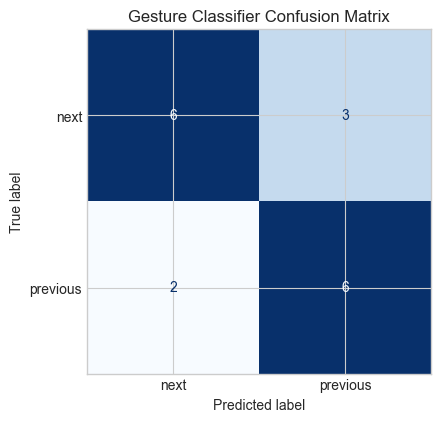

In [8]:
cm = confusion_matrix(best_model_result["y_test"], best_model_result["y_pred"], labels=best_model_result["model"].classes_)
fig, ax = plt.subplots(figsize=(4.5, 4.5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_result["model"].classes_)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Gesture Classifier Confusion Matrix")
plt.tight_layout()
plt.show()


## Phase 4 - Application Layer (Webcam ROI + Slide Control)
Goals:
- Use a fixed Region of Interest (ROI) on the webcam feed (green box strategy) per the pipeline.
- Reuse the preprocessing steps (grayscale, resize, HOG) before calling the trained SVM.
- Apply a confidence threshold + cooldown to debounce gestures before sending `pyautogui` keyboard events (`right` = next, `left` = previous).
- Keep the loop modular so it can be imported into the final demo script.


In [9]:
def preprocess_roi_for_inference(frame, roi_bounds, hog_params, target_size):
    x0, y0, x1, y1 = roi_bounds
    roi_frame = frame[y0:y1, x0:x1]
    gray = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, target_size)
    normalized = resized.astype("float32") / 255.0
    descriptor = hog(normalized, **hog_params)
    return descriptor.reshape(1, -1)


def run_gesture_controller(
    model_path: Path = MODEL_BUNDLE_PATH,
    roi_bounds: Tuple[int, int, int, int] = (200, 120, 440, 360),
    confidence_threshold: float = 0.65,
    cooldown_seconds: float = 2.0,
):
    """Live webcam loop that triggers PowerPoint/Keynote hotkeys via pyautogui."""
    import pyautogui
    import time

    bundle = joblib.load(model_path)
    clf = bundle["model"]
    hog_params = bundle["hog_params"]
    target_size = tuple(bundle["target_size"])

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError("Unable to open webcam. Ensure a camera is connected and not in use.")

    last_trigger = 0.0
    try:
        while True:
            ok, frame = cap.read()
            if not ok:
                break

            descriptor = preprocess_roi_for_inference(frame, roi_bounds, hog_params, target_size)
            proba = clf.predict_proba(descriptor)[0]
            top_idx = int(np.argmax(proba))
            predicted_label = clf.classes_[top_idx]
            confidence = float(proba[top_idx])

            color = (0, 255, 0) if confidence >= confidence_threshold else (0, 165, 255)
            x0, y0, x1, y1 = roi_bounds
            cv2.rectangle(frame, (x0, y0), (x1, y1), color, 2)
            cv2.putText(
                frame,
                f"{predicted_label} ({confidence:.2f})",
                (x0, y0 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                color,
                2,
            )

            if confidence >= confidence_threshold and (time.time() - last_trigger) >= cooldown_seconds:
                key_to_press = "right" if predicted_label == "next" else "left"
                pyautogui.press(key_to_press)
                last_trigger = time.time()
                print(f"Triggered {predicted_label} at confidence {confidence:.2f}")

            cv2.imshow("Hand Gesture Controller", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()


# Example usage (run only when you are ready for the live demo):
# run_gesture_controller(roi_bounds=(220, 140, 460, 380))


## Phase 5 - Reporting, Demo, and Next Steps
- **Report assets:**
  - Include `artifact/crop_manifest.csv`, `hog_metadata.csv`, and the confusion matrix figure. These back Methodology + Results sections (LO1-4 coverage).
  - Document HOG hyperparameters, SVM settings, and ROI coordinates inside the report.
- **Demo video checklist:**
  - Show the green ROI overlay, explain the debounce logic, and demonstrate both `next` and `previous` triggers.
  - Mention explicitly that only conventional models + HOG features are used (matches project constraints).
- **Future experiments:** try additional descriptors (LBP, Hu moments), add data augmentation on crops, or tune SVM `C`/`gamma` via grid search for higher accuracy.
- **Verification:** rerun Phases 1-4 whenever the dataset grows, then regenerate metrics for the final submission package.
